# Image Classification 
### Dalam submission ini saya akan klasifikasi gambar. Klasifikasi di bagi menjadi 3 kelas yaitu gambar anjing, kucing dan laba-laba. 
### Beberapa gambaran dari proses dan hasil dalam submission ini yaitu,
1. Dataset memiliki 12000 sampel.
2. Data memiliki 3 kelas.
3. Model menggunakan Conv2D Maxpooling Layer.
4. Menggunakan model sequential.
5. Dataset dibagi menjadi 80% train set dan 20% test set.
6. Menulis kode untuk menyimpan model ke dalam format TF-Lite.
7. Mengimplementasikan callback.
8. Membuat plot loss dan akurasi.
9. Mengimplementasikan teknik diluar modul.
10. Akurasi dari model mencapai 92%.

## 1. Download Dataset kemudian ekstrak.
Sebelum mendownload dataset. kita setting terlebih dahulu kaggle api nya.

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = 'drive/My Drive/Pengembangan-ML/Submission_Final'

In [ ]:
! kaggle datasets download --force -d tongpython/cat-and-dog -p "drive/My Drive/Pengembangan-ML/Submission_Final/dataset"

In [ ]:
def unzip_dataset(dir):
  zip_ref = zipfile.ZipFile(dir, 'r')
  zip_ref.extractall('drive/My Drive/Pengembangan-ML/Submission_Final/dataset')
  zip_ref.close()

In [ ]:
import zipfile
dir = 'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/cat-and-dog.zip'
unzip_dataset(dir)

In [ ]:
! kaggle datasets download --force -d kdnishanth/animal-classification -p "drive/My Drive/Pengembangan-ML/Submission_Final/dataset"


In [ ]:
dir = 'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/animal-classification.zip'
unzip_dataset(dir)

In [ ]:
import shutil

In [ ]:
original = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/spyder/spyder'
target = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/train'
shutil.move(original,target)

In [ ]:
original = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/training_set/training_set/cats'
target = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/train'
shutil.move(original,target)

original = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/training_set/training_set/dogs'
target = r'drive/My Drive/Pengembangan-ML/Submission_Final/dataset/train'
shutil.move(original,target)

## 2. Import library

In [1]:
import zipfile
import os
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'drive/My Drive/Pengembangan-ML/Submission_Final/dataset'
train_dir = os.path.join(base_dir,'train')

## 3. Check distribusi dari data.

In [2]:
train_image_list = os.listdir(train_dir)
print(train_image_list)

['cats', 'dogs', 'spyder']


In [3]:
dogs = len([name for name in os.listdir(train_dir + '/dogs') if os.path.isfile(os.path.join(train_dir + '/dogs', name))])
cats = len([name for name in os.listdir(train_dir + '/cats') if os.path.isfile(os.path.join(train_dir + '/cats', name))])
spyder = len([name for name in os.listdir(train_dir + '/spyder') if os.path.isfile(os.path.join(train_dir + '/spyder', name))])

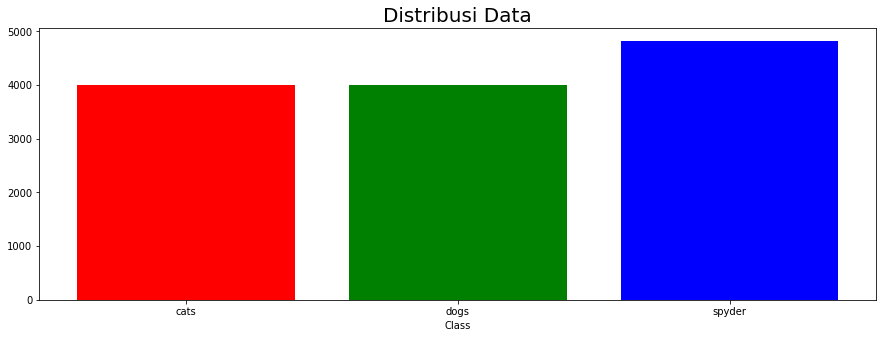

In [4]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.bar(train_image_list, [cats, dogs, spyder], color = ['red', 'green', 'blue'])
plt.xlabel('Class')
plt.title('Distribusi Data',
          fontsize=20);

## 4. Membagi data training dan Validation
Pada bagian ini validasi data yaitu sebesar 20 % dari total data.

In [5]:
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest',
                    validation_split=0.2) #Membagi data train dan validasi sebesar 80 dan 20 persen.

In [6]:
train_generator = train_datagen.flow_from_directory(
        train_dir,  
        target_size=(150, 150),  
        batch_size=4,
        class_mode='categorical',
        subset='training')
 
validation_generator = train_datagen.flow_from_directory(
        train_dir, 
        target_size=(150, 150), 
        batch_size=4, 
        class_mode='categorical',
        subset='validation') 

Found 10261 images belonging to 3 classes.
Found 2565 images belonging to 3 classes.


## 5. Menampilkan resolusi gambar.
### Disini yang di cek hanya 100 dari masing-masing class sehingga total yg di cek 300 dari 12000 data gambar. Diharapkan sudah dapat mewakili seluruh gambar bahwa resolusi dari setiap gambar berbeda-beda.

In [7]:
import os
from PIL import Image
def get_resolution(folder_images, size_images, i = 0):
  for dirpath, _, filenames in os.walk(folder_images):
      for path_image in filenames:
          image = os.path.abspath(os.path.join(dirpath, path_image))
          with Image.open(image) as img:
              width, heigth = img.size
              if i < 100:
                size_images.append(width * heigth)
                i = i + 1
              else:
                break

In [ ]:
size_images = []
get_resolution(os.path.join(train_dir,'dogs'), size_images)
get_resolution(os.path.join(train_dir,'cats'), size_images)
get_resolution(os.path.join(train_dir,'spyder'), size_images)

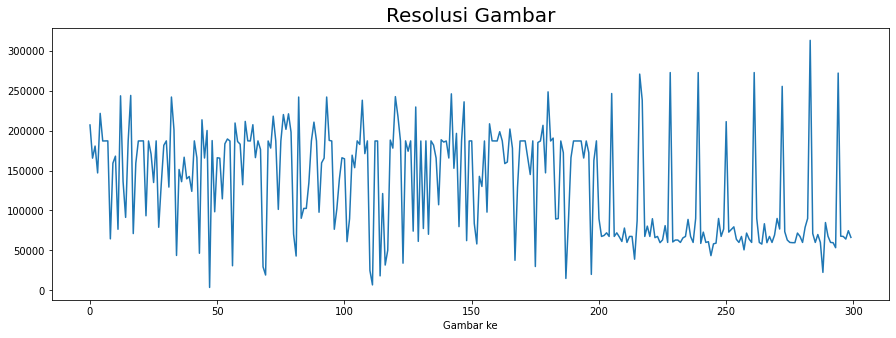

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(size_images)
plt.xlabel('Gambar ke')
plt.title('Resolusi Gambar',
          fontsize=20);

## 6. Create Model Sequential
Pada bagian ini disematkan transfer learning ResNet serta di implementasikan Conv2D dan MaxPooling2D layer.

In [8]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import ResNet152V2

def create_model():
  return tf.keras.models.Sequential([
    ResNet152V2(weights="imagenet", include_top=False, input_tensor=Input(shape=(150, 150, 3))),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(), 
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
  ])
  model.layers[0].trainable = False

## 7. Callback
salah satu callback yg digunakan adalah ketika akurasi mencapai 92%.
Selain itu callback untuk menampilkan plot menggunakan tensorboard juga di gunakan.

In [9]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      print("accuracy trainning dan validasi diatas  92%!")
      self.model.stop_training = True
callbacks = myCallback()

In [10]:
import datetime, os
import time
%load_ext tensorboard

## 8. Training Model

In [12]:
start = time.time()

model = create_model()
model.compile(loss='mse',
            optimizer=tf.optimizers.SGD(),
            metrics=['accuracy'])

logdir = os.path.join(base_dir + "/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history = model.fit(train_generator,
                    validation_data=validation_generator,
                    epochs=1000,
                    callbacks=[callbacks, tensorboard_callback], 
                    steps_per_epoch = 500, 
                    # validation_steps = 1
                    )

finish = time.time() - start
durasi = time.strftime("%H:%M:%S", time.gmtime(finish))
print('Lama pelatihan %s menit' %(durasi))

Epoch 1/1000
500/500 [==============================] - 2283s 5s/step - loss: 0.1052 - accuracy: 0.7675 - val_loss: 0.0663 - val_accuracy: 0.8651
Epoch 2/1000
500/500 [==============================] - 2294s 5s/step - loss: 0.0708 - accuracy: 0.8460 - val_loss: 0.0662 - val_accuracy: 0.8550
Epoch 3/1000
500/500 [==============================] - 2315s 5s/step - loss: 0.0616 - accuracy: 0.8750 - val_loss: 0.0451 - val_accuracy: 0.9060
Epoch 4/1000
500/500 [==============================] - 2429s 5s/step - loss: 0.0582 - accuracy: 0.8820 - val_loss: 0.0382 - val_accuracy: 0.9201
Epoch 5/1000
500/500 [==============================] - 2381s 5s/step - loss: 0.0492 - accuracy: 0.8995 - val_loss: 0.0372 - val_accuracy: 0.9251
Epoch 6/1000
500/500 [==============================] - 2421s 5s/step - loss: 0.0448 - accuracy: 0.9095 - val_loss: 0.0385 - val_accuracy: 0.9236
Epoch 7/1000
500/500 [==============================] - 2467s 5s/step - loss: 0.0405 - accuracy: 0.9180 - val_loss: 0.0362 -

In [19]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152v2 (Functional)     (None, 5, 5, 2048)        58331648  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 64)          1179712   
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               33280     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 3)                

## 9. Konversi Model tflite

In [13]:
# Konversi model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with tf.io.gfile.GFile(base_dir + '/model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmp98_625a8/assets


# 10. Upload plot akurasi dan loss di tensorboard.dev
Plot akurasi dan loss untuk membandingkan ketika training dan validation bisa di cek live pada tensorboard.dev agar ukuran notebook tidak terlalu besar. (mengikuti saran dari submission Time Series)

In [18]:
! tensorboard dev upload --logdir '/content/drive/My Drive/Pengembangan-ML/Submission_Final/dataset/logs' \
    --name "Submission Final" \
    --description "Last Submission From dicoding.com about image classification"

2020-09-10 09:27:53.138589: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Data for the "graphs" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "histograms" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Data for the "hparams" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
Upload started and will continue reading any new data as it's added
to the logdir. To stop uploading, press Ctrl-C.

View your TensorBoard live at: https://tensorboard.dev/experiment/kn9WwtjuQGiE5cqMo1tjUQ/

[2020-09-10T09:27:55] Uploader started.
[2020-09-10T09:27:5